In [1]:
#importing libraries
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import cv2
import imghdr
import numpy as np

In [2]:
gpus = tf.config.experimental.list_physical_devices('CPU')
gpus

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

helps prevent tensorflow using all the VRAM by setting GPU MEMORY GROWTH


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu,True)
    

removing dodgy images

In [4]:

data_dir = 'data'
data_dir_vals = os.listdir(data_dir)
print(data_dir_vals)
image_exts = ['jpeg','jpg','bmp','png']

#removing images under 10KB manually

#Now removing the dodgy images
for image_class in data_dir_vals:
    for image in os.listdir(os.path.join(data_dir,image_class)): #to get all images in the subfoler 'happy and 'sad
        image_path = os.path.join(data_dir,image_class,image)
        try:
            img = cv2.imread(image_path)
            tip = imghdr.what(image_path)
            if tip not in image_exts:
                print('Image Not in ext list {}'.format(image_path))
                os.remove(image_path)
        except Exception as e:
            print('Issue with Image {}'.format(image_path))
            #os.remove(image_path)
             


['happy', 'sad']


Loading the data


In [5]:
data = tf.keras.utils.image_dataset_from_directory('data')
#we cannot access this data pipeline as it is put directly into the memory
#let us access the data pipeline by
data_iterator = data.as_numpy_iterator()

Found 615 files belonging to 2 classes.


accessing data pipelines individual batches

In [6]:

batch = data_iterator.next()
print(len(batch))
#it prints two as output which means there are two parts to this data set
#1)images 2)labels 

#to get images we say
#print(batch[0])

#To get the labels
print(batch[1])

#if we see the shape 
print(batch[0].shape)


2
[0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0 0 1 1 0]
(32, 256, 256, 3)


To know which label is assigned to 'happy' and 'sad' we use this piece of code


In [7]:
# fig,ax = plt.subplots(ncols=4,figsize = (20,20))

# for idx,img in enumerate(batch[0][:4]):
#     ax[idx].imshow(img)
#     ax[idx].title.set_text(batch[1][idx])
    
# #Hence we can see that label '0' is given to happy
# #and label 1 to 'sad'

# #each time we say batc.next() we get new batch of images

let us pre-process the data

the pixel values matrix will be in range 0 to 255 but it makes it hard

when we take long data and do deep learninig models

hence we try to scale it to 0-1,we say

In [8]:

batch_scaled = batch[0]/255
#print(f"Max : {batch_scaled.max()} , Min  : {batch_scaled.min()}\n")

#hence to do this to each and every bathc in the data pipeline we use
scaled_data = data.map(lambda x,y: (x/255,y)) #x is for imagesy for labels
#this effectively  speeds up how quickly we want to access our data from the disk

#and we can see the batches by
scaled_iterator = scaled_data.as_numpy_iterator()
batch = scaled_iterator.next()
batch[0].max()

1.0

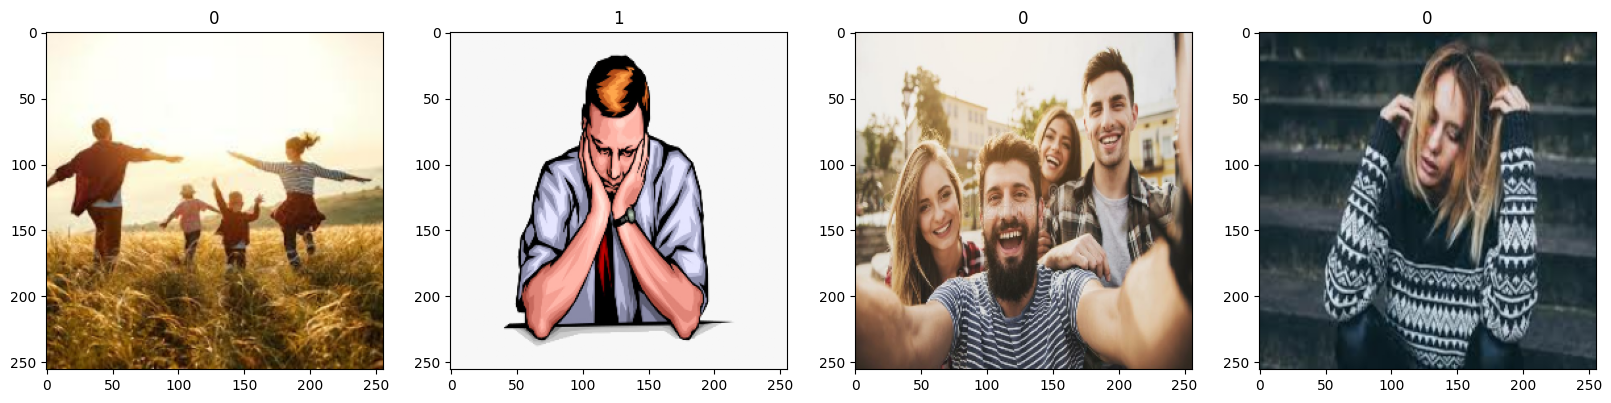

In [9]:
fig,ax = plt.subplots(ncols=4,figsize = (20,20))

for idx,img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

Now we are going to spilt the data into training and testing

In [10]:
len(scaled_data)

20

Hence we are gonna have 20 batches which has 32 images each

Let us take 70% of data as our training size and 20% data for validation size and rest 10% as testing size

In [11]:
train_size = 14 #70%

val_size = 4 #20%

test_size = 2 #10%

print(train_size,val_size,test_size)

14 4 2


data.take : How much data we can take in that partition

data.skip : Gives us what partition to be skipped



In [12]:
train = scaled_data.take(train_size)

val = scaled_data.skip(train_size).take(val_size)

test = scaled_data.skip(train_size+val_size).take(val_size)

In [13]:
len(test)

2

Let us Now build the Deep Learning Model (Deep Neural Network)

We are taking Sequential as we want our DL Model to go from top to bottom .It is quick and easy

In [14]:
#Taking important libraries 
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D,MaxPooling2D,Dense,Flatten,Dropout

model = Sequential()

In [15]:
#MaxPooling2D??

We have 3 Convolution Blocks with maxpooling (which takes max value before 'relu' activation ang that output : used to condense the information)

In [16]:
model.add(Conv2D(16,(3,3),1,activation = 'relu',input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1,activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1,activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten()) 

model.add(Dense(256,activation = 'relu')) #256 neurons in our neural network
model.add(Dense(1,activation = 'sigmoid')) #final single dense output layer (0-happy,1-sad)

Before Flattern() we get a multiple outputs from different filters which are used 16,31,16.Hence for each we get 256 different outputs

Hence we use the Flattern() to condense all the outputs into one single output

Now we compile the Neural Network

In [17]:
model.compile('adam',loss = tf.losses.BinaryCrossentropy(),metrics = ['accuracy'])

'adam' is an optimizer and loss is 'BinaryCrossentropy' which is used for binary (0,1)

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

Now Let us train our Deep Learning Model

One 'epoch' is one run over the entire training set of data

after training we take the evaluation data

In [19]:
#helps us to view the steps and make changes to our NN
logdir = 'logs'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)
#we will be able to get the history of all the training information
hist = model.fit(train,epochs = 20 ,validation_data = val,callbacks=[tensorboard_callback])

Epoch 1/20
14/14 [==============================] - 44s 3s/step - loss: 0.5920 - accuracy: 0.7857 - val_loss: 0.3480 - val_accuracy: 0.8828
Epoch 2/20
14/14 [==============================] - 27s 2s/step - loss: 0.4505 - accuracy: 0.8259 - val_loss: 0.4714 - val_accuracy: 0.7891
Epoch 3/20
14/14 [==============================] - 26s 2s/step - loss: 0.4484 - accuracy: 0.8125 - val_loss: 0.4975 - val_accuracy: 0.7578
Epoch 4/20
14/14 [==============================] - 26s 2s/step - loss: 0.4203 - accuracy: 0.8259 - val_loss: 0.3637 - val_accuracy: 0.8516
Epoch 5/20
14/14 [==============================] - 26s 2s/step - loss: 0.3499 - accuracy: 0.8527 - val_loss: 0.2998 - val_accuracy: 0.8516
Epoch 6/20
14/14 [==============================] - 27s 2s/step - loss: 0.3085 - accuracy: 0.8772 - val_loss: 0.3500 - val_accuracy: 0.8828
Epoch 7/20
14/14 [==============================] - 26s 2s/step - loss: 0.2572 - accuracy: 0.8884 - val_loss: 0.2017 - val_accuracy: 0.9219
Epoch 8/20
14/14 [==

In [20]:
hist.history #we ca see the information of everything using history

{'loss': [0.5920104384422302,
  0.4505217969417572,
  0.44839176535606384,
  0.4202595055103302,
  0.3498738408088684,
  0.30847471952438354,
  0.25716570019721985,
  0.18506300449371338,
  0.11696231365203857,
  0.10286195576190948,
  0.13505485653877258,
  0.08541398495435715,
  0.09327668696641922,
  0.09560788422822952,
  0.09053070843219757,
  0.04707344248890877,
  0.040235962718725204,
  0.020571071654558182,
  0.02946256287395954,
  0.011149340309202671],
 'accuracy': [0.7857142686843872,
  0.8258928656578064,
  0.8125,
  0.8258928656578064,
  0.8526785969734192,
  0.8772321343421936,
  0.8883928656578064,
  0.9330357313156128,
  0.9508928656578064,
  0.9620535969734192,
  0.9464285969734192,
  0.9776785969734192,
  0.9754464030265808,
  0.9598214030265808,
  0.9709821343421936,
  0.9821428656578064,
  0.9888392686843872,
  0.9955357313156128,
  0.9888392686843872,
  1.0],
 'val_loss': [0.34796786308288574,
  0.47140419483184814,
  0.4975050687789917,
  0.36369839310646057,
  0

Now let us plot the 'loss','validation_loss'

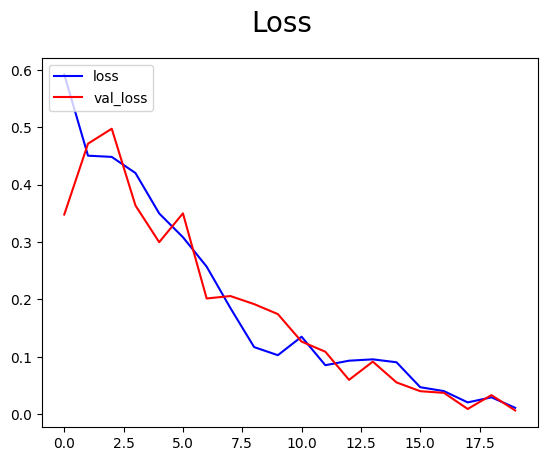

In [102]:
fig = plt.figure()

plt.plot(hist.history['loss'],color = 'blue',label = 'loss')
plt.plot(hist.history['val_loss'],color = 'red',label = 'val_loss')

fig.suptitle('Loss',fontsize = 20)
plt.legend(loc = "upper left")
plt.show()


If we see our LOSS going down and VALIDATION LOSS going Up, it can be the sign of overfitting and

 hence regularization techniques must be applied

If You dont see any decrease in the LOSS then we need to relook in to the training data

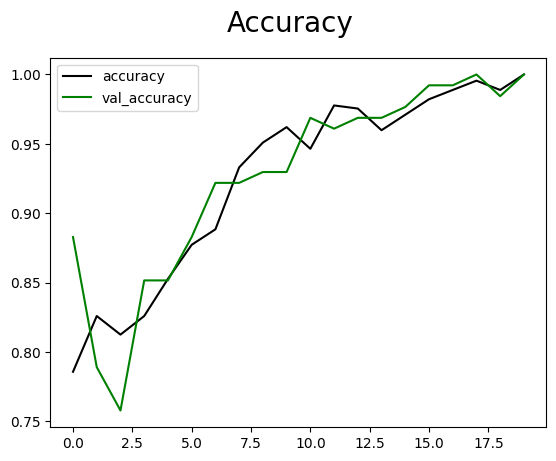

In [103]:
#to see the accuracy values
fig = plt.figure()

plt.plot(hist.history['accuracy'],color = 'black',label = 'accuracy')
plt.plot(hist.history['val_accuracy'],color = 'green',label = 'val_accuracy')

fig.suptitle('Accuracy',fontsize = 20)
plt.legend(loc = "upper left")
plt.show()


Let us evaluate the performance

In [104]:
from tensorflow.keras.metrics import Precision,Recall,BinaryAccuracy
pre = Precision()
re = Recall()
acc = BinaryAccuracy()

In [105]:
for batch in test.as_numpy_iterator():
    X,y = batch
    y_pred = model.predict(X)
    pre.update_state(y,y_pred)
    re.update_state(y,y_pred)
    acc.update_state(y,y_pred)

1/1 [==============================] - 0s 187ms/step


In [106]:
print(f'Precision : {pre.result().numpy()},Recall : {re.result().numpy()},Accuracy : {acc.result().numpy()}')

Precision : 1.0,Recall : 1.0,Accuracy : 1.0


High precision means your model is performing better

High recall means your performing better


NOW LET US TAKE AN IMAGE WHICH OUR MODEL HAS NEVER SEEN BEFORE


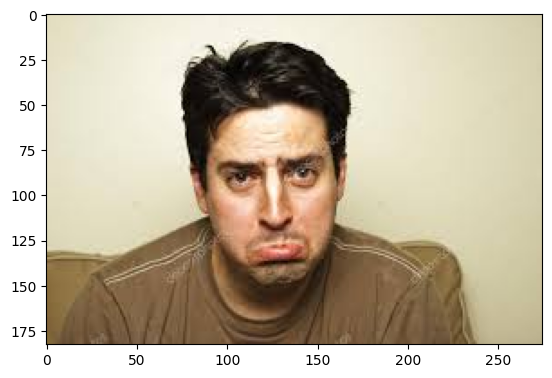

In [155]:
img = cv2.imread('sad_test.jpeg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

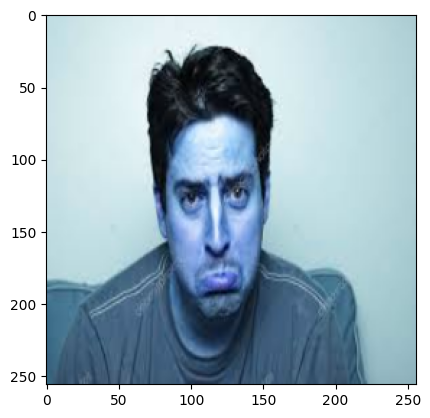

In [156]:
resize_test_img_sad = tf.image.resize(img,(256,256))
plt.imshow(resize_test_img_sad.numpy().astype(int))
plt.show()

In [157]:
resize_test_img_sad.shape

TensorShape([256, 256, 3])

In [158]:
np.expand_dims(resize_test_img_sad,0).shape

(1, 256, 256, 3)

In [159]:
y_pred_sad = model.predict(np.expand_dims(resize_test_img_sad/255,0))
y_pred_sad

1/1 [==============================] - 0s 71ms/step


array([[0.97350353]], dtype=float32)

In [160]:
if y_pred_sad > 0.5:
    print("Predicted class is SAD")
else:
    print("Predicted Class is HAPPY")

Predicted class is SAD


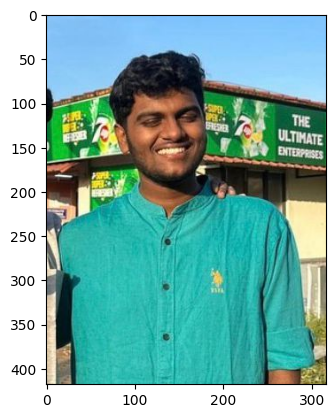

In [161]:
img = cv2.imread('happy_test.jpg')
plt.imshow(cv2.cvtColor(img,cv2.COLOR_BGR2RGB))
plt.show()

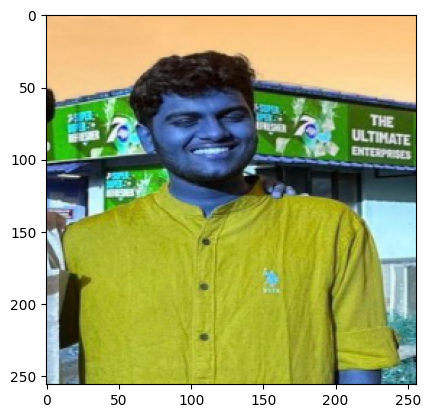

In [162]:
resize_test_img_happy = tf.image.resize(img,(256,256))
plt.imshow(resize_test_img.numpy().astype(int))
plt.show()

In [163]:
y_pred_happy = model.predict(np.expand_dims(resize_test_img_happy/255,0))
y_pred_happy


1/1 [==============================] - 0s 87ms/step


array([[0.1351453]], dtype=float32)

In [164]:
if y_pred_happy > 0.5:
    print("Predicted class is SAD")
else:
    print("Predicted Class is HAPPY")

Predicted Class is HAPPY


HENCE WE CAN CONCLUDE THAT IN A BINARY CLASSIFICATION 

IF WE GET A VALUE LESS THAN 50% (<0.5), THEN WE CAN SAY IMAGE->HAPPY

IF WE GET A VALUE MORE THAN 50% (>0.5), THEN WE CAN SAY IMAGE->SAD

Let us now save the model

In [165]:
from tensorflow.keras.models import load_model

model.save(os.path.join('models','happy_sad_model.h5'))


1/1 [==============================] - 0s 112ms/step


LOADING THE MODEL

In [ ]:

newmodel = load_model(os.path.join('models','happy_sad_model.h5'))
y_pred_new = newmodel.predict(np.expand_dims(resize_test_img_sad/255,0))


In [166]:
#reload the model in a new vaiable

if y_pred_new > 0.5:
    print("Predicted class is SAD")
else:
    print("Predicted Class is HAPPY")

Predicted class is SAD
